# Testing the model performance

Load in the previously trained models.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import joblib

tfidf_path = "/content/drive/My Drive/BA THESIS/trained_nb_model/tfidf_vectorizer.pkl"
model_nb_path = "/content/drive/My Drive/BA THESIS/trained_nb_model/naive_bayes_model.pkl"

In [3]:
import joblib

# Load the TF-IDF vectorizer
tfidf_vectorizer = joblib.load(tfidf_path)

# Load the trained Naïve Bayes model
naive_bayes_model = joblib.load(model_nb_path)

In [4]:
file_path_bert_model = "/content/drive/My Drive/BA THESIS/trained_bert_model/bert_model"
file_path_bert_tokenizer = "/content/drive/My Drive/BA THESIS/trained_bert_model/bert_tokenizer"

In [5]:
from transformers import TFBertForSequenceClassification, BertTokenizer


In [6]:
tokenizer_bert = BertTokenizer.from_pretrained(file_path_bert_tokenizer)

In [7]:
model_bert = TFBertForSequenceClassification.from_pretrained(file_path_bert_model)

Some layers from the model checkpoint at /content/drive/My Drive/BA THESIS/trained_bert_model/bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_455']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/BA THESIS/trained_bert_model/bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without 

The test data set is loaded, the preprocessed for Naive Bayes and for BERT.

In [8]:
import pandas as pd

In [9]:
# load test data
nb_test_path = "/content/drive/My Drive/BA THESIS/data/test_NB_lem.csv"
bert_test_path = "/content/drive/My Drive/BA THESIS/data/test_BERT.csv"

In [10]:

nb_test = pd.read_csv(nb_test_path)
bert_test = pd.read_csv(bert_test_path)


## Testing Naive Bayes

First the classification is run with Naive Bayes. The results are investigated in a confusion matrix as well as the classic metrics (accuracy, recall, precision, F1).

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


In [12]:
x = tfidf_vectorizer.transform(nb_test['text'])

In [13]:
y_actual = nb_test['ground_truth']

In [14]:
y_pred = naive_bayes_model.predict(x)

In [15]:
# Create the confusion matrix
labels = ["positive", "neutral", "negative"]  # Define order of labels
conf_matrix = confusion_matrix(y_actual, y_pred, labels=labels)
conf_matrix = pd.DataFrame(conf_matrix, columns=labels, index=labels)
conf_matrix.index.name = "Actual"
conf_matrix.columns.name = "Predicted"

conf_matrix

Predicted,positive,neutral,negative
Actual,,,
positive,1051,223,353
neutral,446,692,478
negative,257,234,1136


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


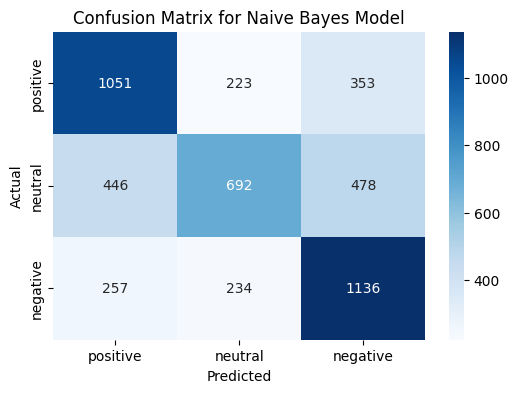

In [17]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Naive Bayes Model")
plt.savefig("/content/drive/My Drive/BA THESIS/graphs/testing/NB_confusion_matrix.png", dpi=300)  # Save as PNG
plt.show()

In [18]:
# Compute accuracy
accuracy = accuracy_score(y_actual, y_pred)

# Compute precision, recall, F1-score (macro-averaged across all classes)
precision = precision_score(y_actual, y_pred, average="macro")
recall = recall_score(y_actual, y_pred, average="macro")
f1 = f1_score(y_actual, y_pred, average="macro")

# Store metrics in a Pandas DataFrame
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Value": [accuracy, precision, recall, f1]
})

print(metrics_df)

      Metric     Value
0   Accuracy  0.591170
1  Precision  0.592998
2     Recall  0.590803
3   F1-score  0.584806


In [19]:
metrics_df.to_csv("/content/drive/My Drive/BA THESIS/graphs/testing/NB_metrics.csv", index=False)

## Bert testing

Here the test set is supplied to the pretrained BERT model. The same accuracy metrics and confusion matrix is calculated.

In [20]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from sklearn.metrics import f1_score
import numpy as np

In [21]:
label_encoder = LabelEncoder()
bert_test["label"] = label_encoder.fit_transform(bert_test["ground_truth"])


In [22]:
def tokenize_function(text):
    return tokenizer_bert(
        text,
        truncation=True,
        padding="longest",  # or use "longest" for dynamic padding
        max_length=200,       # since we are using headlines
        return_tensors="tf"
    )

# Tokenize texts and extract tensors
tokenized_test = tokenize_function(bert_test["text"].tolist())


In [23]:
logits = model_bert.predict(tokenized_test).logits

# Convert logits to class predictions
y_pred_bert = tf.argmax(logits, axis=-1).numpy()

153/153 [==============================] - 42s 216ms/step


In [24]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
predicted_labels_bert = [label_map[pred] for pred in y_pred_bert]

In [25]:
labels = ["positive", "neutral", "negative"]  # Define order of labels
conf_matrix_2 = confusion_matrix(bert_test["ground_truth"].tolist(), predicted_labels_bert, labels=labels)
conf_matrix_2 = pd.DataFrame(conf_matrix_2, columns=labels, index=labels)
conf_matrix_2.index.name = "Actual"
conf_matrix_2.columns.name = "Predicted"

conf_matrix_2

Predicted,positive,neutral,negative
Actual,,,
positive,1236,220,171
neutral,194,1223,199
negative,180,242,1205


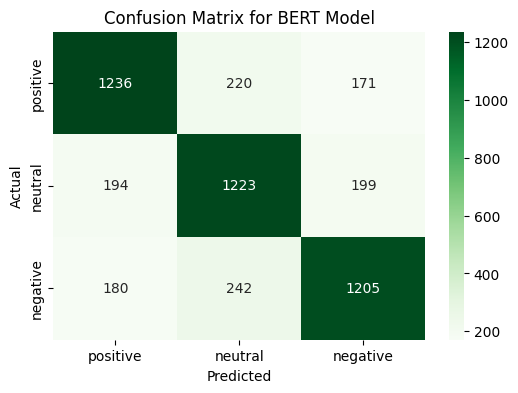

In [26]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_2, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for BERT Model")
plt.savefig("/content/drive/My Drive/BA THESIS/graphs/testing/BERT_confusion_matrix.png", dpi=300)  # Save as PNG
plt.show()

In [27]:
# Compute accuracy
accuracy_2 = accuracy_score(bert_test["ground_truth"].tolist(), predicted_labels_bert)

# Compute precision, recall, F1-score (macro-averaged across all classes)
precision_2 = precision_score(bert_test["ground_truth"].tolist(), predicted_labels_bert, average="macro")
recall_2 = recall_score(bert_test["ground_truth"].tolist(), predicted_labels_bert, average="macro")
f1_2 = f1_score(bert_test["ground_truth"].tolist(), predicted_labels_bert, average="macro")

# Store metrics in a Pandas DataFrame
metrics_df_2 = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "Value": [accuracy_2, precision_2, recall_2, f1_2]
})

print(metrics_df_2)

      Metric     Value
0   Accuracy  0.752361
1  Precision  0.752866
2     Recall  0.752371
3   F1-score  0.752437


In [28]:
metrics_df_2.to_csv("/content/drive/My Drive/BA THESIS/graphs/testing/BERT_metrics.csv", index=False)

## Topic analysis

In this section, the performance of the trained generic models are evaluated on each topic. Recall: the dataset used is assembled from 5 different datasets (news, finance, movie, reddit, twitter).

In [29]:
all_pred_df = pd.DataFrame({
    "Topic": bert_test["topic"],
    "Text": bert_test["text"],
    "Actual": nb_test['ground_truth'],
    "NB_pred": y_pred,
    "BERT_pred": predicted_labels_bert
})

all_pred_df.head()

,Topic,Text,Actual,NB_pred,BERT_pred
0,movie,catalog every bodily fluids gag something mary,neutral,negative,neutral
1,movie,incredibly flexible cast,positive,positive,positive
2,twitter,shameful statement aap sanjay singh downgrade ...,neutral,negative,neutral
3,twitter,name hindu terrorist spread hates modi govt ac...,neutral,negative,neutral
4,twitter,send modi shah pakistan,neutral,neutral,neutral


In [30]:
all_pred_df.to_csv("/content/drive/My Drive/BA THESIS/all_predictions.csv", index=False)

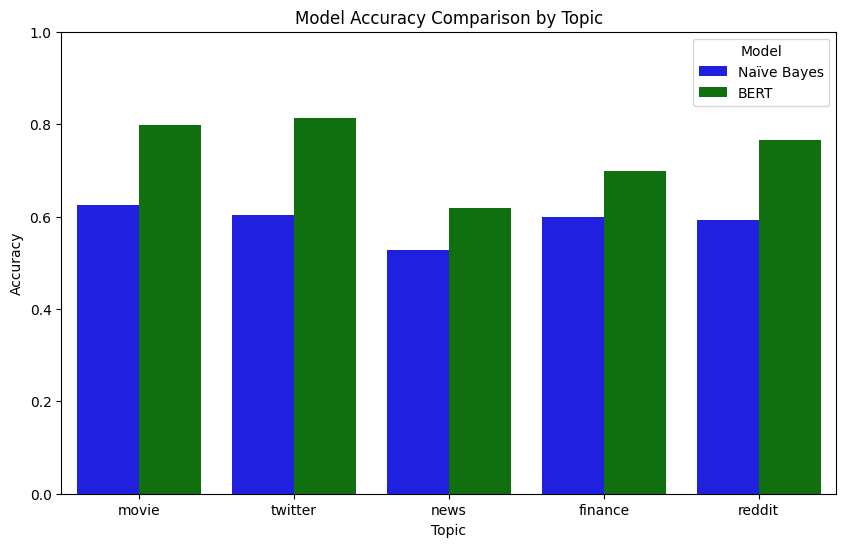

In [31]:
# Accuracies

# Calculate accuracy for each topic and model
accuracy_data = []

for topic in all_pred_df["Topic"].unique():
    df_topic = all_pred_df[all_pred_df["Topic"] == topic]

    # Compute accuracy for Naïve Bayes
    acc_nb = accuracy_score(df_topic["Actual"], df_topic["NB_pred"])

    # Compute accuracy for BERT
    acc_bert = accuracy_score(df_topic["Actual"], df_topic["BERT_pred"])

    # Append data
    accuracy_data.append({"Topic": topic, "Model": "Naïve Bayes", "Accuracy": acc_nb})
    accuracy_data.append({"Topic": topic, "Model": "BERT", "Accuracy": acc_bert})

# Convert to DataFrame for plotting
accuracy_df = pd.DataFrame(accuracy_data)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_df, x="Topic", y="Accuracy", hue="Model", palette=["blue", "green"])

# Labels and title
plt.xlabel("Topic")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison by Topic")
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.legend(title="Model")

plt.savefig("/content/drive/My Drive/BA THESIS/graphs/testing/accuracy_comparison_topics.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()


In [32]:
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df
# Save accuracy data as CSV
accuracy_df.to_csv("/content/drive/My Drive/BA THESIS/graphs/testing/accuracy_results_topic.csv", index=False)

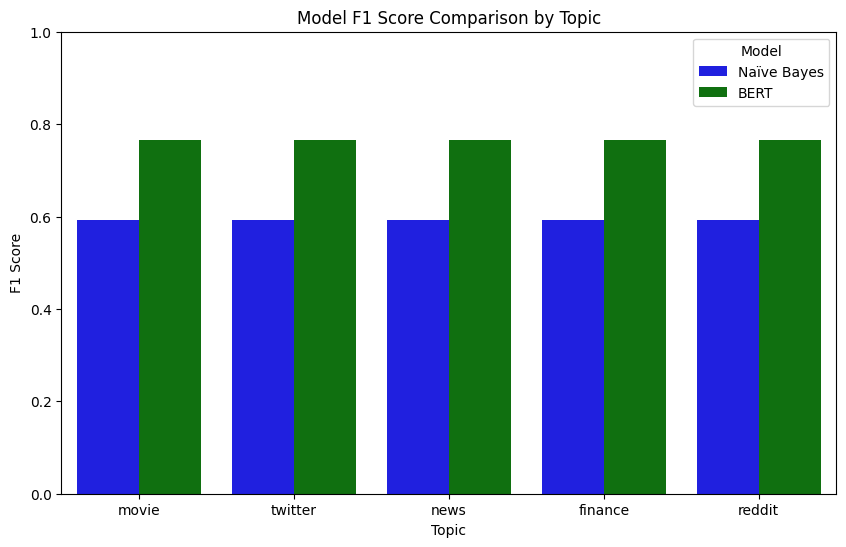

In [33]:
# F1

# Calculate f1 for each topic and model
f1_data = []

for topic in all_pred_df["Topic"].unique():
    df_topic = all_pred_df[all_pred_df["Topic"] == topic]

    # Compute f1 for Naïve Bayes
    f1_nb = f1_score(df_topic["Actual"], df_topic["NB_pred"], average="macro")

    # Compute f1 for BERT
    f1_bert = f1_score(df_topic["Actual"], df_topic["BERT_pred"], average="macro")

    # Append data
    f1_data.append({"Topic": topic, "Model": "Naïve Bayes", "F1": acc_nb})
    f1_data.append({"Topic": topic, "Model": "BERT", "F1": acc_bert})

# Convert to DataFrame for plotting
f1_df = pd.DataFrame(f1_data)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=f1_df, x="Topic", y="F1", hue="Model", palette=["blue", "green"])

# Labels and title
plt.xlabel("Topic")
plt.ylabel("F1 Score")
plt.title("Model F1 Score Comparison by Topic")
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.legend(title="Model")

plt.savefig("/content/drive/My Drive/BA THESIS/graphs/testing/f1_comparison_topics.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

In [34]:
f1_df = pd.DataFrame(f1_data)
f1_df
# Save accuracy data as CSV
f1_df.to_csv("/content/drive/My Drive/BA THESIS/graphs/testing/f1_results_topic.csv", index=False)

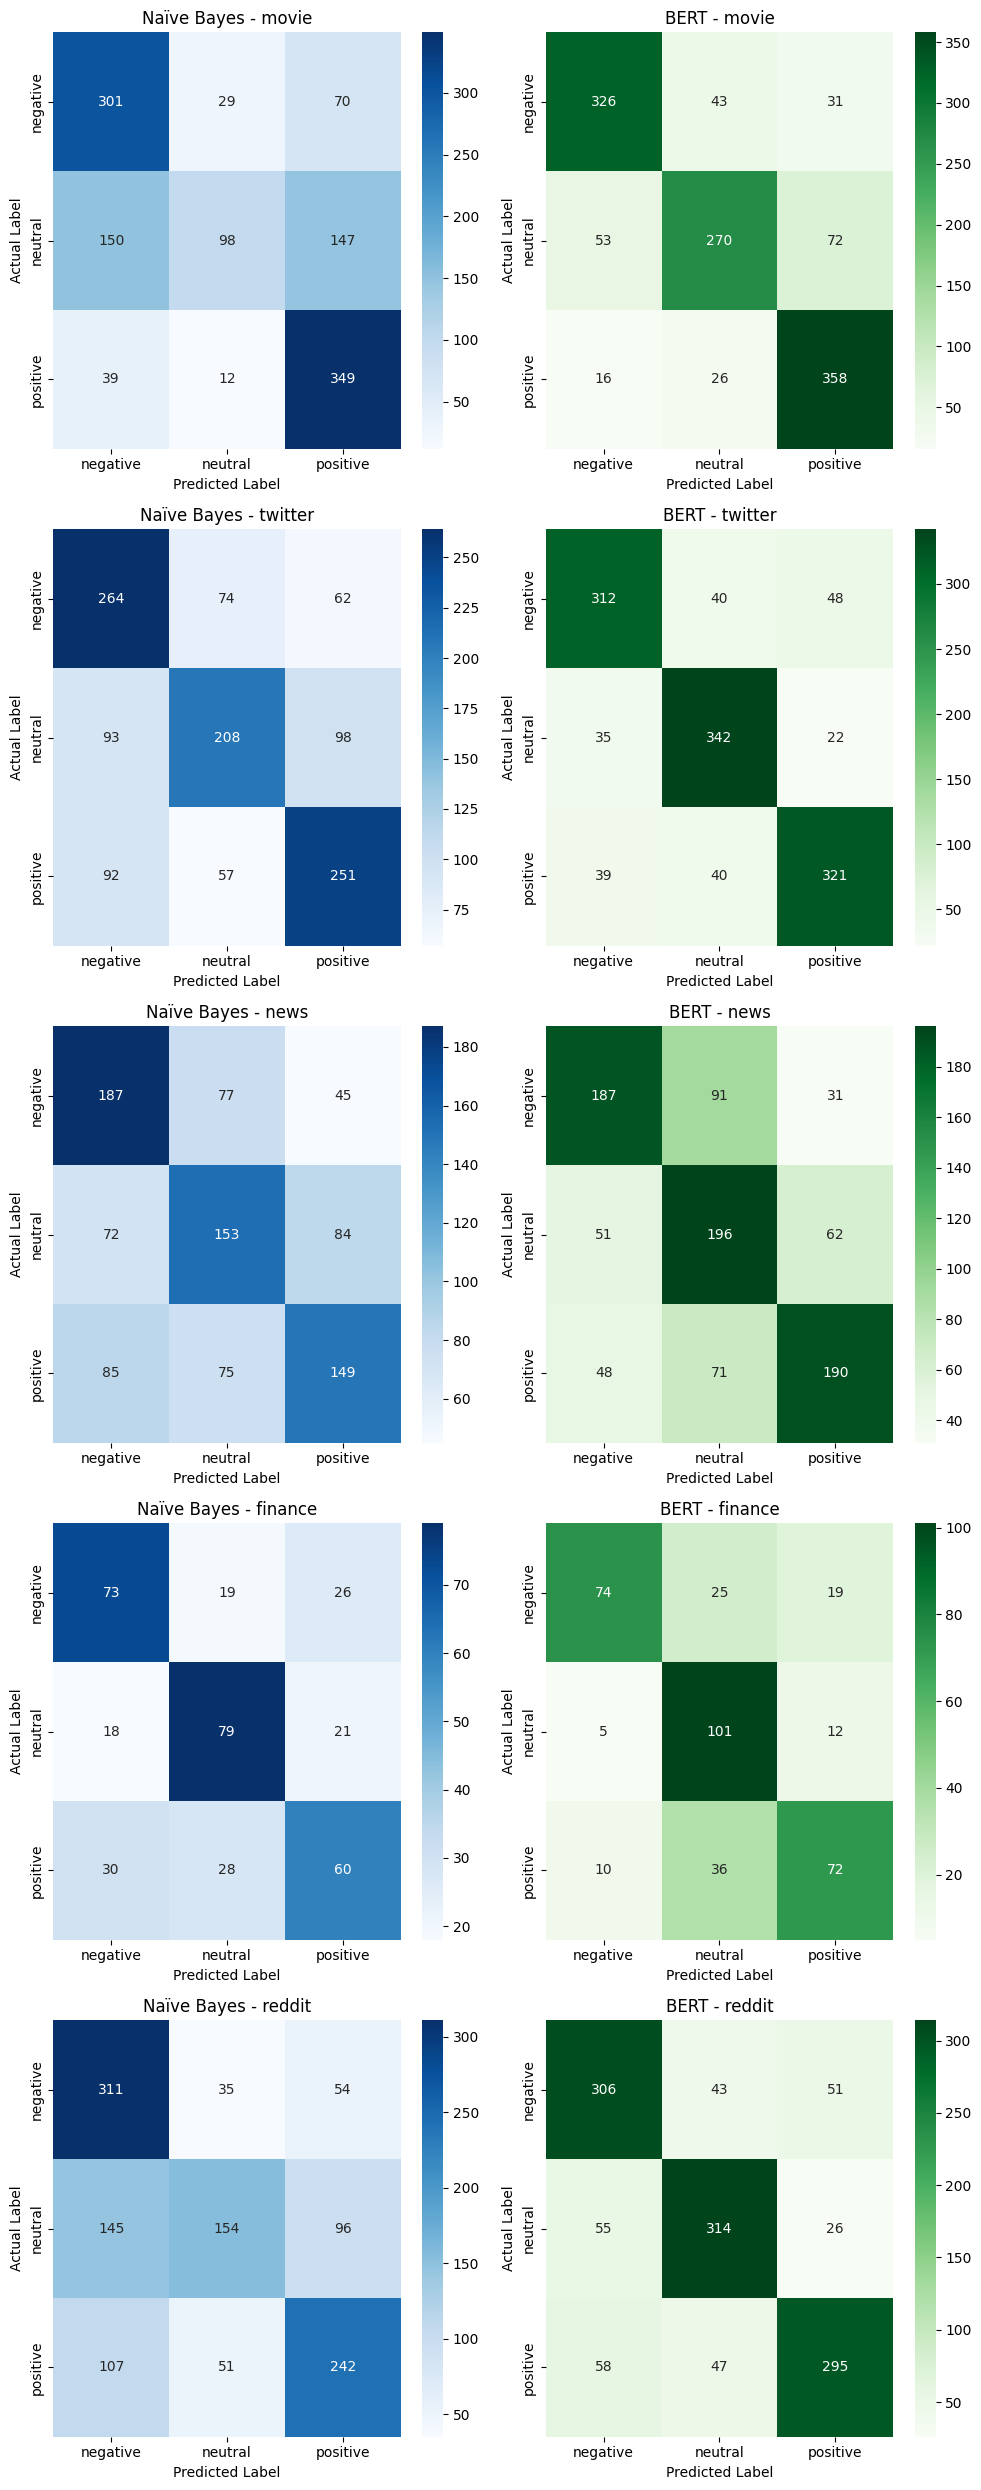

In [35]:

# Unique topics in the dataset
topics = all_pred_df["Topic"].unique()

# Set up subplots (one row per topic, two columns: NB and BERT)
fig, axes = plt.subplots(len(topics), 2, figsize=(10, len(topics) * 5))

# Loop through topics
for i, topic in enumerate(topics):
    df_topic = all_pred_df[all_pred_df["Topic"] == topic]

    # Compute confusion matrices
    cm_nb = confusion_matrix(df_topic["Actual"], df_topic["NB_pred"], labels=["negative", "neutral", "positive"])
    cm_bert = confusion_matrix(df_topic["Actual"], df_topic["BERT_pred"], labels=["negative", "neutral", "positive"])

    # Define color maps
    cmap_nb = sns.color_palette("Blues", as_cmap=True)
    cmap_bert = sns.color_palette("Greens", as_cmap=True)

    # Plot Naïve Bayes confusion matrix (left column)
    sns.heatmap(cm_nb, annot=True, fmt="d", cmap=cmap_nb, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"], ax=axes[i, 0])
    axes[i, 0].set_title(f"Naïve Bayes - {topic}")
    axes[i, 0].set_xlabel("Predicted Label")
    axes[i, 0].set_ylabel("Actual Label")

    # Plot BERT confusion matrix (right column)
    sns.heatmap(cm_bert, annot=True, fmt="d", cmap=cmap_bert, xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"], ax=axes[i, 1])
    axes[i, 1].set_title(f"BERT - {topic}")
    axes[i, 1].set_xlabel("Predicted Label")
    axes[i, 1].set_ylabel("Actual Label")

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot
plt.savefig("/content/drive/My Drive/BA THESIS/graphs/testing/topic_wise_confusion_matrices.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()
